# Исследование поведения гравитационной функции в модели поиска матрицы корреспонденции на примере данных города Москва.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
print pd.__version__

0.24.2


## Постановка задачи и описание данных:
<!-- $d^{real}_{ij}$ - реальная корреспонденция между районами $i$ и $j$ (*n_livers_i_to_j*) -->
<!-- корреспонденция - ср объем пользователей, вот добираются из а в б -->
$L_i$ - полное число людей, ездящих на работу из района $i$ ($\sum\limits_{zone_i} d_{zone_ij}$)

$W_j$ - полное число людей, приезжающих на работу в район $j$ ($\sum\limits_{zone_j} d_{izone_j}$)

$c_{ij}$ - издержки на перемещение из $i$ в $j$ (**время**)

$F(c_{ij})$ - гравитационная функция от издержек 

$n =$ num_of_regions

<!-- (предположительно, убывающая) -->
****

**Гравитационная модель** матрицы корреспонденций имеет вид:
$$d_{ij} = A_iB_jL_iW_jF(c_{ij})$$



Предположим, что **экспоненциальная модель** $F(c_{ij})$ имеет вид
$$F(c_{ij}) = \dfrac{1}{\exp(\alpha t_{ij}^\beta)}$$

> **Требуется оптимизировать** точность и скорость поиска параметров $\alpha$ и $\beta$ и **проверить гипотезу** о том, что хвост гравитационной функции убывает по степенному закону, а на малых значениях затрат ее зависимость ностит степенной характер.
Для этого **минимизируем** разброс гравитационной ф-ции для похожих значений $c_{ij}$

**Note** В задаче предлагается ввести поправку $\cdot 1.62$ к корреспонденции из Москвы (районы 0 - 10), т.к. население Москвы во столько раз больше населения области, а число опрошенных из Москвы и из области одинаково. Однако, это просто изменило бы оптимальное значение коэффициентов $L_{i}$ и не повлияло бы на скорость сходимости метода, оптимальные значения $\alpha$ и $\beta$ или их невязку. Поэтому без ограничения общности, будем рассматривать модель без поправки.

## Чтение данных

In [3]:
data_col_names = ["source", "sink", "corresp_real", "avg_time", "avg_distance"]
data = pd.read_csv("trips.csv", names=data_col_names)

print(data.shape)
data.head(20)

(210, 5)


,source,sink,corresp_real,avg_time,avg_distance
0,1,1,40,26,2.2
1,1,2,4,49,8.1
2,1,3,3,35,6.8
3,1,4,2,75,9.3
4,1,5,2,30,8.0
5,1,6,4,52,9.9
6,1,7,6,48,13.0
7,1,8,3,48,12.3
8,1,11,1,30,16.9
9,1,13,2,50,21.9


Для удобства обработки, приведем данные к матричной форме.

Дополним строками, соответствующими нулевой корреспонденции - в них положим "corresp" = 0, "avg_time" = np.Inf, "avg_distance = np.Inf"

Такие данные могут "испортить" оценку гравитационной функции, но не могут испортить оценку теоретической корреспонденции.

In [4]:
n_district = 22

In [5]:
data_zero = pd.DataFrame()
for source in range(1, n_district+1):
    for sink in range(1, n_district+1):
        if not ((data["source"] == source) & (data["sink"] == sink)).any():
            data_zero_new = pd.DataFrame(data=np.array([[source, sink, 0, np.Inf, np.Inf]]),
                                         columns=data_col_names)
            
            data_zero = pd.concat([data_zero, data_zero_new], axis = 0)
            

In [6]:
# ?pd.DataFrame

In [7]:
data_m = pd.concat([data, data_zero], axis=0)
data_m.sort_values(by=["source", "sink"], inplace=True)
data_m.reset_index(drop=True, inplace=True);

In [29]:
M_corresp_real = np.array(data_m["corresp_real"].values).reshape([n_district, n_district]).astype(float)
M_avg_time = np.array(data_m["avg_time"].values).reshape([n_district, n_district]).astype(float)

# print M_avg_time

# print M_corresp_real
# Значение $M[i][j]$ соответствует источнику i+1 и стоку j+1.

In [24]:
L = M_corresp_real.sum(axis=1)
W = M_corresp_real.sum(axis=0)

# Убедимся, что в L и W нет нулевых элементов
print L
print W

# Sanity check
print L.sum(), "==", W.sum()

[ 67. 122. 126.  98. 113. 116. 128. 118.  83.   7. 124. 245. 117.  87.
 118.  75.  67.  66.  46.   7.  13.  22.]
[351. 141. 115. 109. 107. 118. 100. 140.  63.   7.  76. 158.  95.  60.
  84.  57.  55.  56.  37.   5.  12.  19.]
1965.0 == 1965.0


## Визуализация данных
Для этого рассчитаем "идеальную" гравитационную функцию, при применении которой к конечным временам, мы получим точные реальные корреспонденции. (Для удобства визуализации "идеальную" гравитационную функцию определим на исходный данных, не дополненных нулями и np.Inf)

$$F_{ideal}(c_{ij}) = \dfrac{d_{ij}}{A_iB_jL_iW_j}$$

Для начала можно положить:
$$A_{i_{init}} = [1]_{1*n}$$
$$B_{j_{init}} = [1]_{1*n}$$


In [10]:
def plot_log_ideal_F(A, B):
    F_ideal = np.array([float(data["corresp_real"][k]) / (A[data["source"][k] - 1] *
                                                          B[data["sink"][k] - 1] *
                                                          L[data["source"][k] - 1] *
                                                          W[data["sink"][k] - 1])
                       for k in range(data.shape[0])])
    
    F_ideal_log = -np.log(F_ideal)
    plt.scatter(x=data["avg_time"], y=F_ideal_log, alpha=0.64, c="#1c74b2")
    plt.show()
    

In [11]:
# Положим коэффициенты по умолчанию 1
A_0 = np.ones((n_district))
B_0 = np.ones((n_district))

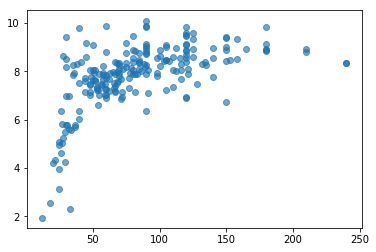

In [12]:
plot_log_ideal_F(A_0, B_0)

Данную визуализацию можно использовать для демонстрации сходимости метода Sinkhorn, подставляя A и B, полученные в результате итераций метода.

## Метод Sinkhorn

In [13]:
def calc_corresp_loss(c_theor, c_real):
    corresp_num = n_district ** 2
    corresp_diff = np.array(c_theor).reshape(corresp_num) - np.array(c_real).reshape(corresp_num)
    return np.sum((corresp_diff * corresp_diff)) / corresp_num

In [14]:
def calc_corresp_theor(A, B, gravity_func=None, **kwargs):
    return (A.reshape((n_district, 1)) * np.array(L).reshape((n_district, 1)) *
           (B.reshape((n_district, 1)) * np.array(W).reshape((n_district, 1))).T * gravity_func(**kwargs))

In [33]:
def sh_iterate(A, B, gravity_func, **kwargs):
    A_new = (1.0 / ((B.reshape((n_district, 1)).T * W.reshape((n_district, 1)).T * gravity_func(**kwargs)).sum(axis = 1, keepdims=True)))
    B_new = (1.0 / ((A_new * L.reshape((n_district, 1)) * gravity_func(**kwargs)).sum(axis = 0))).T
    return A_new.reshape(A.shape), B_new.reshape(B.shape)

In [26]:
def sh_balance(A_0=np.random.uniform(1e-8, 1, n_district),
               B_0=np.random.uniform(1e-8, 1, n_district),
               n_iter=100, # total iterations num
               n_illustrated=0, # the number of iterations, for which F_ideal plots will be drawn
               step_illustrated=10,
               precision=1e-4,
               gravity_func=None, **kwargs):
    
    A, B = A_0.copy(), B_0.copy()
    result = {"converged" : False,
              "n_iter" : 0,
              "losses" : [],
              "A_deltas" : [],
              "B_deltas" : []}
    
    for i in range(n_iter):
        A_new, B_new = sh_iterate(A, B, gravity_func, **kwargs)
        
        if np.linalg.norm(A_new, ord=2) <= 1e-20:
            print "ACHTUNG: A"
            print A_new
            return result
        
        if np.linalg.norm(B_new, ord=2) <= 1e-20:
            print "ACHTUNG: B"
            print B_new
            return result
            
        A_delta = np.linalg.norm(A - A_new, ord=2) / np.linalg.norm(A, ord=2)
        B_delta = np.linalg.norm(B - B_new, ord=2) / np.linalg.norm(B, ord=2)
        A = A_new.copy()
        B = B_new.copy()
        
        loss = calc_corresp_loss(M_corresp_real, calc_corresp_theor(A, B, gravity_func, **kwargs))
        
        result["n_iter"] = i + 1
        result["losses"].append(loss)
        result["A_deltas"].append(A_delta)
        result["B_deltas"].append(B_delta)
        
        if (i % step_illustrated == 0) and (i / step_illustrated < n_illustrated):
            print "iteration:", i+1
            plot_log_ideal_F(A, B)
        
        if (A_delta <= precision): # and B_delta <=precision
            result["converged"] = True
            break
        
    return result

*Sanity check*

In [17]:
def gravity_exp1(avg_time, alpha):
    return 1.0 / np.exp(avg_time * alpha)

In [34]:
A_n, B_n = sh_iterate(A=A_0, B=B_0, 
                      gravity_func=gravity_exp1, 
                      avg_time=M_avg_time, 
                      alpha=0.076)

print A_n.shape, B_n.shape

(22,) (22,)


iteration: 1


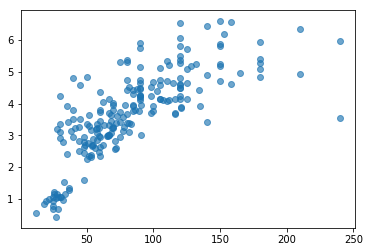

[0.9041158808357935, 0.23310987886923953, 0.12828553832595327, 0.08155993572858138, 0.05508429561168605, 0.03842464063784193, 0.02728029039260057, 0.01955978909676631, 0.014110754721411434, 0.010228244570214283, 0.007448143216068947, 0.005451377922888024, 0.004013674651444075, 0.002975796001839936, 0.00222422879600091, 0.0016779515844284314, 0.0012791180787845358, 0.000986421481798, 0.0007703503093334887, 0.0006097956241472838, 0.0004896280157604486, 0.0003989711435729696, 0.0003299753313208455, 0.0002769493337370525, 0.0002357474123254488, 0.00020333696846421467, 0.00017749263943622097, 0.00015657826509590824, 0.000139389809996761, 0.00012504090772530398, 0.00011287870871935142, 0.00010242170945606992, 9.331379745026445e-05]

[3.1278249228346517, 0.33160744110354956, 0.15077920068685033, 0.10510718448444917, 0.08470071425214283, 0.0717259817225217, 0.061977341795732714, 0.054153695804958865, 0.047696302585251614, 0.042279797331485895, 0.037679730622053174, 0.033731039132483584, 0.0303

In [35]:
sh_result = sh_balance(n_iter=10000,
                       n_illustrated=10,
                       step_illustrated=50,
                       gravity_func=gravity_exp1, avg_time=M_avg_time, alpha=0.046)

print sh_result["A_deltas"]
print
print sh_result["B_deltas"]